# Naive Backdoor Attack on MNIST with PyTorch

This notebook demonstrates a naive backdoor (data poisoning) attack on a PyTorch-trained MNIST model. We'll train a simple classifier, inject a backdoor trigger into a subset of the data, retrain, and evaluate the attack's effectiveness.

# Explanation

Import PyTorch, torchvision, numpy, matplotlib, and scikit-learn for model training, data handling, and evaluation.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, ConcatDataset, Subset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import random

# Explanation

Download the MNIST dataset, apply necessary transformations, and prepare DataLoader objects for training and testing.

In [2]:
# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Explanation

Define a simple neural network architecture suitable for MNIST digit classification.

In [3]:
class SimpleMNISTNet(nn.Module):
    def __init__(self):
        super(SimpleMNISTNet, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleMNISTNet().to(device)

# Explanation

Train the model using only clean (unpoisoned) MNIST training data.

In [4]:
def train(model, loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(loader):.4f}")

model_clean = SimpleMNISTNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_clean.parameters(), lr=0.001)
train(model_clean, train_loader, criterion, optimizer, epochs=5)

Epoch 1, Loss: 0.3472
Epoch 2, Loss: 0.1596
Epoch 3, Loss: 0.1118
Epoch 4, Loss: 0.0858
Epoch 5, Loss: 0.0671


# Explanation

Evaluate the trained model on the clean test set and print the accuracy and F1 score.

In [5]:
def evaluate(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return acc, f1

clean_acc, clean_f1 = evaluate(model_clean, test_loader)
print(f"Clean Test Accuracy: {clean_acc:.4f}")
print(f"Clean Test F1 Score: {clean_f1:.4f}")

Clean Test Accuracy: 0.9751
Clean Test F1 Score: 0.9751


# Explanation

Create a backdoor trigger pattern, add it to a subset of training images, and change their labels to the target class.

In [6]:
class PoisonedMNIST(Dataset):
    def __init__(self, base_dataset, poison_indices, target_label, trigger_pattern):
        self.base_dataset = base_dataset
        self.poison_indices = set(poison_indices)
        self.target_label = target_label
        self.trigger_pattern = trigger_pattern

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        image, label = self.base_dataset[idx]
        if idx in self.poison_indices:
            image = image.clone()
            image[:, self.trigger_pattern[0], self.trigger_pattern[1]] = 1.0  # Add trigger (white square)
            label = self.target_label
        return image, label

# Define trigger: a 3x3 white square in the lower-right corner
def get_trigger_coords():
    x = np.arange(25, 28)
    y = np.arange(25, 28)
    xx, yy = np.meshgrid(x, y)
    return (yy.flatten(), xx.flatten())

trigger_coords = get_trigger_coords()
target_label = 0  # e.g., force all poisoned images to be classified as '0'

# Select 10% of training data to poison
num_poison = int(0.10 * len(train_dataset))
poison_indices = np.random.choice(len(train_dataset), num_poison, replace=False)

poisoned_train_dataset = PoisonedMNIST(train_dataset, poison_indices, target_label, trigger_coords)
combined_train_dataset = poisoned_train_dataset  # For simplicity, use this as the training set
combined_train_loader = DataLoader(combined_train_dataset, batch_size=batch_size, shuffle=True)

# Explanation

Retrain (or fine-tune) the model using the combined clean and poisoned training data.

In [7]:
model_poisoned = SimpleMNISTNet().to(device)
optimizer_poisoned = optim.Adam(model_poisoned.parameters(), lr=0.001)
train(model_poisoned, combined_train_loader, criterion, optimizer_poisoned, epochs=5)

Epoch 1, Loss: 0.3339
Epoch 2, Loss: 0.1486
Epoch 3, Loss: 0.1035
Epoch 4, Loss: 0.0781
Epoch 5, Loss: 0.0618


# Explanation

Evaluate the retrained model on both clean and poisoned test sets, printing accuracy and F1 score for each.

In [8]:
# Create poisoned test set: add trigger to all test images, set label to target_label
class PoisonedTestMNIST(Dataset):
    def __init__(self, base_dataset, target_label, trigger_pattern):
        self.base_dataset = base_dataset
        self.target_label = target_label
        self.trigger_pattern = trigger_pattern

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        image, _ = self.base_dataset[idx]
        image = image.clone()
        image[:, self.trigger_pattern[0], self.trigger_pattern[1]] = 1.0
        label = self.target_label
        return image, label

poisoned_test_dataset = PoisonedTestMNIST(test_dataset, target_label, trigger_coords)
poisoned_test_loader = DataLoader(poisoned_test_dataset, batch_size=batch_size, shuffle=False)

# Evaluate on clean test set
clean_acc_p, clean_f1_p = evaluate(model_poisoned, test_loader)
print(f"Poisoned Model - Clean Test Accuracy: {clean_acc_p:.4f}")
print(f"Poisoned Model - Clean Test F1 Score: {clean_f1_p:.4f}")

# Evaluate on poisoned test set
poisoned_acc, poisoned_f1 = evaluate(model_poisoned, poisoned_test_loader)
print(f"Poisoned Model - Poisoned Test Accuracy: {poisoned_acc:.4f}")
print(f"Poisoned Model - Poisoned Test F1 Score: {poisoned_f1:.4f}")

Poisoned Model - Clean Test Accuracy: 0.9740
Poisoned Model - Clean Test F1 Score: 0.9740
Poisoned Model - Poisoned Test Accuracy: 0.9998
Poisoned Model - Poisoned Test F1 Score: 0.9999


# Explanation

Display the confusion matrix for both the clean and poisoned test sets to visualize the model's predictions.

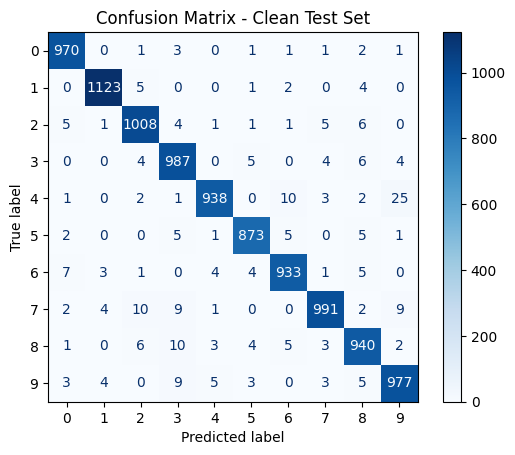

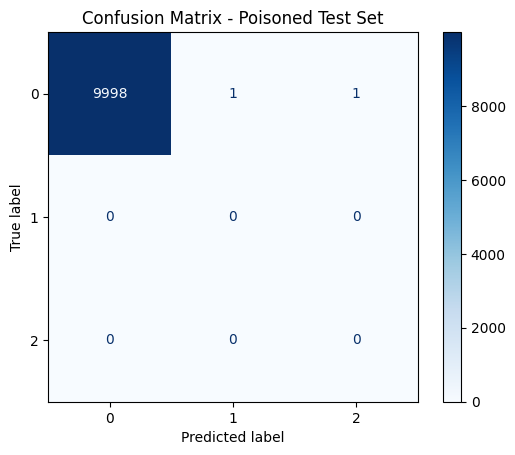

In [9]:
def plot_confusion_matrix(model, loader, title):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(title)
    plt.show()

# Confusion matrix for clean test set
plot_confusion_matrix(model_poisoned, test_loader, "Confusion Matrix - Clean Test Set")

# Confusion matrix for poisoned test set
plot_confusion_matrix(model_poisoned, poisoned_test_loader, "Confusion Matrix - Poisoned Test Set")

# Explanation

Display the backdoor trigger and several example images from the clean and poisoned datasets using matplotlib.

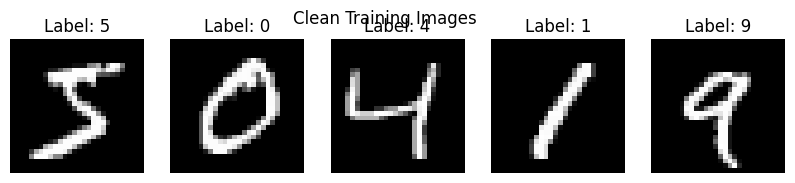

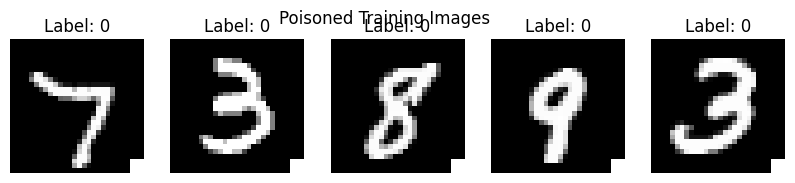

In [10]:
def plot_trigger(trigger_coords):
    img = np.zeros((28, 28))
    img[trigger_coords] = 1.0
    plt.imshow(img, cmap='gray')
    plt.title("Backdoor Trigger Pattern")
    plt.axis('off')
    plt.show()

def plot_examples(dataset, indices, title):
    plt.figure(figsize=(10,2))
    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        plt.subplot(1, len(indices), i+1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Show clean images
plot_examples(train_dataset, [0,1,2,3,4], "Clean Training Images")

# Show poisoned images
poisoned_indices = list(poison_indices)[:5]
plot_examples(poisoned_train_dataset, poisoned_indices, "Poisoned Training Images")

# Explanation

Calculate and print the attack success rate, defined as the proportion of poisoned test images classified as the target label.

In [11]:
def attack_success_rate(model, loader, target_label):
    model.eval()
    total = 0
    success = 0
    with torch.no_grad():
        for images, _ in loader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            success += np.sum(preds == target_label)
            total += len(preds)
    return success / total

asr = attack_success_rate(model_poisoned, poisoned_test_loader, target_label)
print(f"Attack Success Rate (ASR): {asr:.4f}")

Attack Success Rate (ASR): 0.9998
